In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import time
import gc

from datetime import datetime

sns.set(style='whitegrid')

pd.set_option('display.max_columns', None)  

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

### Resume

This notebook presents a tree based modeling approach, using LightGBM.

In [2]:
# To force some binary varibles to be read as str
dtypes = \
{
    'projectid': str,
    'teacher_acctid': str,                                                                              
    'school_metro': str,                                          
    'school_charter': str,                                
    'teacher_prefix': str,                                        
    'teacher_teach_for_america': str,                                                                                             
    'eligible_double_your_impact_match': str,                      
    'eligible_almost_home_match': str,                                                                                                                                                      
}

In [3]:
df = pd.read_csv('../Data/Kaggle/KDDCup14/feature_selection.csv', dtype=dtypes)

In [4]:
categorical = list(df.select_dtypes(include=[object]).columns)

In [5]:
categorical

['projectid',
 'teacher_acctid',
 'school_metro',
 'school_charter',
 'teacher_prefix',
 'teacher_teach_for_america',
 'primary_focus_subject',
 'resource_type',
 'eligible_double_your_impact_match',
 'eligible_almost_home_match',
 'date_posted',
 'short_description']

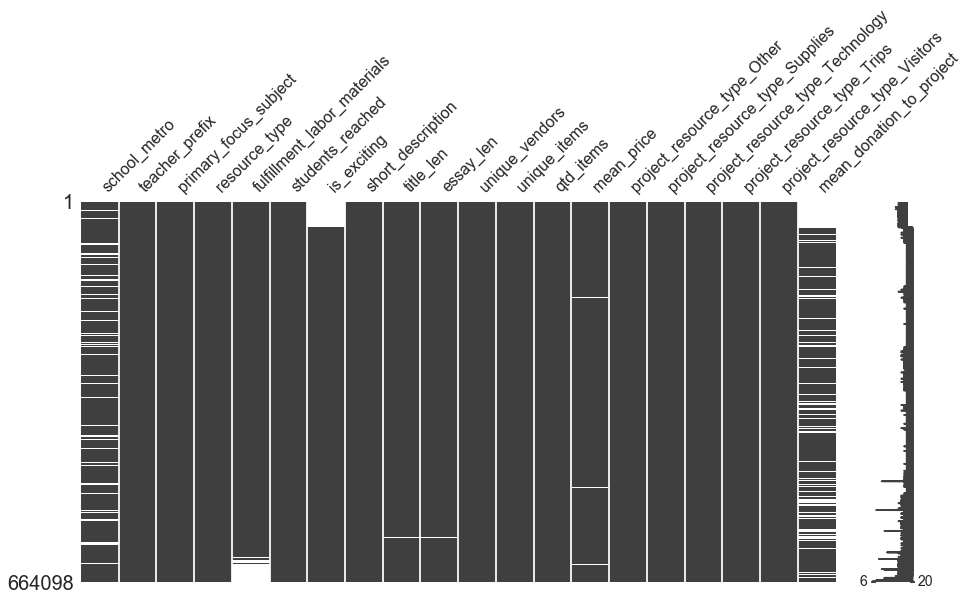

In [6]:
missing_columns = df.columns[df.isnull().any()].tolist()
msno.matrix(df[missing_columns], figsize=(15, 7))

In [7]:
# Encoding categorical features

from sklearn.preprocessing import LabelEncoder

categorical = list(df.select_dtypes(include=[object]).columns)
exclude = ['projectid', 'teacher_acctid', 'short_description', 'date_posted']

to_consider = [cat for cat in categorical if not cat in exclude]

le = LabelEncoder()
for cat in to_consider:
        print(cat)
        df[cat] = le.fit_transform(df[cat].astype(str))
        print(le.classes_)
        print(le.transform(le.classes_))

school_metro
['nan' 'rural' 'suburban' 'urban']
[0 1 2 3]
school_charter
['0' '1']
[0 1]
teacher_prefix
['Dr.' 'Mr.' 'Mr. & Mrs.' 'Mrs.' 'Ms.' 'nan']
[0 1 2 3 4 5]
teacher_teach_for_america
['0' '1']
[0 1]
primary_focus_subject
['Applied Sciences' 'Character Education' 'Civics & Government'
 'College & Career Prep' 'Community Service' 'ESL' 'Early Development'
 'Economics' 'Environmental Science' 'Extracurricular' 'Foreign Languages'
 'Gym & Fitness' 'Health & Life Science' 'Health & Wellness'
 'History & Geography' 'Literacy' 'Literature & Writing' 'Mathematics'
 'Music' 'Nutrition' 'Other' 'Parent Involvement' 'Performing Arts'
 'Social Sciences' 'Special Needs' 'Sports' 'Visual Arts' 'nan']
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27]
resource_type
['Books' 'Other' 'Supplies' 'Technology' 'Trips' 'Visitors' 'nan']
[0 1 2 3 4 5 6]
eligible_double_your_impact_match
['0' '1']
[0 1]
eligible_almost_home_match
['0' '1']
[0 1]


In [8]:
for c in categorical:
    df[c] = df[c].astype('category')

In [9]:
# Filling nas for numerical features
numerical = list(df.select_dtypes(include=[np.number]).drop('is_exciting', axis=1).columns)
df.loc[:, numerical].fillna(0, inplace=True)

In [10]:
# Splitting train & validation
df['date_posted'] = pd.to_datetime(df['date_posted'])
df_train = df[(df['date_posted'].dt.year > 2009) & (df['date_posted'].dt.year < 2014)].copy()
df_test = df[df['date_posted'].dt.year >= 2014].copy()

In [11]:
from sklearn.model_selection import GroupShuffleSplit

groups = df_train.groupby(df_train['date_posted'].dt.year).groups

In [12]:
df_train.shape

(439599, 56)

In [13]:
df_test.shape

(44772, 56)

In [14]:
del df
gc.collect()

12160

### Modeling

In [15]:
from sklearn.externals import joblib
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [16]:
df_ids = df_test['projectid'].copy()

In [17]:
df_train.drop(['date_posted', 'projectid', 'teacher_acctid'], axis=1, inplace=True)
df_test.drop(['date_posted', 'projectid', 'teacher_acctid'], axis=1, inplace=True)

#### Baseline

In [18]:
X = df_train.drop(['short_description', 'is_exciting'], axis=1).copy()
y = df_train['is_exciting']

In [19]:
cv = GroupShuffleSplit().split(X, y, groups)

In [20]:
X_ = df_test.drop(['short_description', 'is_exciting'], axis=1).copy()

In [21]:
import lightgbm as lgbm

In [22]:
X.shape

(439599, 51)

In [23]:
y.shape

(439599,)

In [24]:
# Baseline model 

# from sklearn.model_selection import KFold
from sklearn.model_selection import TimeSeriesSplit

clf_lgbm = lgbm.LGBMClassifier(is_unbalance=True, random_state=0, n_jobs=-1)

# cv = KFold(n_splits=10, random_state=0)
cv = TimeSeriesSplit(n_splits=3)

results = cross_val_score(clf_lgbm, X, y, cv=cv, scoring='roc_auc')

print("ROC: %.3f%% (%.3f%%)" % (results.mean()*100.0, results.std()*100.0))

ROC: 88.218% (0.637%)


In [25]:
clf_lgbm.fit(X, y)
y_ = clf_lgbm.predict_proba(X_)

In [26]:
y_.max()

0.8160853587344219

In [27]:
y_[:, 1].max()

0.1839146412655781

In [28]:
df = pd.DataFrame({'projectid': df_ids, 'is_exciting': y_[:, 1].flatten()})

In [29]:
df.head()

,is_exciting,projectid
0,0.183915,316ed8fb3b81402ff6ac8f721bb31192
1,0.183915,90de744e368a7e4883223ca49318ae30
2,0.183915,32943bb1063267de6ed19fc0ceb4b9a7
3,0.183915,bb18f409abda2f264d5acda8cab577a9
4,0.183915,24761b686e18e5eace634607acbcc19f


In [30]:
df.to_csv('../Data/Kaggle/KDDCup14/submission_baseline.csv', index=False)

Score: 0.50000

#### Hyperparameter Tunning

In [31]:
clf_lgbm = lgbm.LGBMClassifier(is_unbalance=True, random_state=0)
model_params = {
    'learning_rate':        [0.08, 1.0],
    'num_leaves':           [30, 50],
    'min_data_in_leaf':     [2, 5, 7],
    'max_depth':            [-1, 5, 10, 15],
    'subsample':            [0.7, 0.9],
    'subsample_freq':       [3, 5, 7],
    'min_data_in_bin':      [3],
    'colsample_bytree':     [0.8, 0.9]
}

grid = RandomizedSearchCV(clf_lgbm, model_params, cv=cv, verbose=1, scoring='roc_auc', \
                          n_jobs=-1, n_iter=200, random_state=0)
grid.fit(X, y)

print (grid.best_params_)
print (grid.best_score_*100)
print (grid.cv_results_['std_test_score'][grid.best_index_]*100)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 10.2min finished


{'subsample_freq': 3, 'subsample': 0.9, 'num_leaves': 30, 'min_data_in_leaf': 5, 'min_data_in_bin': 3, 'max_depth': -1, 'learning_rate': 1.0, 'colsample_bytree': 0.8}
89.22051226189826
0.4949363569467492


In [32]:
y_ = grid.best_estimator_.predict_proba(X_)

In [33]:
y_.max()

0.999994488166441

In [34]:
y_[:, 1].max()

0.006269565513677864

In [35]:
df = pd.DataFrame({'projectid': df_ids, 'is_exciting': y_[:, 1].flatten()})

In [36]:
df.head()

,is_exciting,projectid
0,0.000279,316ed8fb3b81402ff6ac8f721bb31192
1,0.000471,90de744e368a7e4883223ca49318ae30
2,0.000068,32943bb1063267de6ed19fc0ceb4b9a7
3,0.001721,bb18f409abda2f264d5acda8cab577a9
4,0.001107,24761b686e18e5eace634607acbcc19f


In [37]:
df.to_csv('../Data/Kaggle/KDDCup14/submission_LGBM.csv', index=False)

Score: 0.50000

In [38]:
from sklearn.model_selection import train_test_split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)

In [40]:
y_pred = grid.best_estimator_.predict_proba(X_test)[:, 1]

results_report = pd.DataFrame(columns=['Lower', 'Upper', '# 0', '# 1', '% 0', '% 1', 'KS'])
total_0 = len(y_test[y_test == 0])
total_1 = len(y_test[y_test == 1])
for i in np.linspace(0.0, 0.9, 10):
    subgroup = y_test[(y_pred >= i) & (y_pred < i+0.1)]
    count_0 = len(subgroup[subgroup == 0])
    count_1 = len(subgroup[subgroup == 1])
    cum_0 = (results_report.iloc[:int(i*10)]['# 0'].sum()+count_0)/total_0
    cum_1 = (results_report.iloc[:int(i*10)]['# 1'].sum()+count_1)/total_1
    results_report.loc[i] = [i, i+0.1, count_0, count_1, cum_0*100, cum_1*100, (cum_0-cum_1)*100]

In [41]:
results_report.reset_index(drop=True).round(decimals=2)

,Lower,Upper,# 0,# 1,% 0,% 1,KS
0,0.0,0.1,71844.0,42.0,59.46,0.38,59.08
1,0.1,0.2,6918.0,140.0,65.19,1.65,63.54
2,0.2,0.3,5802.0,232.0,69.99,3.75,66.24
3,0.3,0.4,5481.0,333.0,74.52,6.76,67.77
4,0.4,0.5,5119.0,467.0,78.76,10.98,67.78
5,0.5,0.6,5055.0,669.0,82.94,17.03,65.91
6,0.6,0.7,5352.0,1017.0,87.37,26.23,61.14
7,0.7,0.8,5958.0,1661.0,92.31,41.26,51.04
8,0.8,0.9,5936.0,2839.0,97.22,66.94,30.27
9,0.9,1.0,3361.0,3654.0,100.00,100.00,0.00


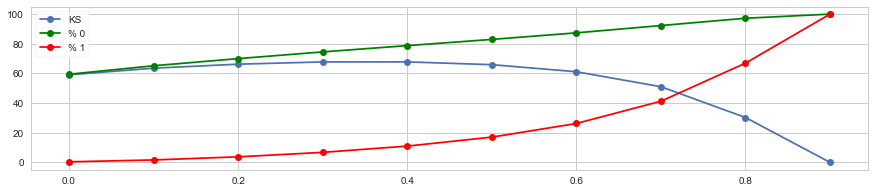

In [42]:
plt.figure(figsize=(15, 3))
plt.plot(results_report['KS'], 'o-')
plt.plot(results_report['% 0'], 'go-')
plt.plot(results_report['% 1'], 'ro-')
plt.legend(frameon=True);